In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e2/sample_submission.csv
/kaggle/input/playground-series-s3e2/train.csv
/kaggle/input/playground-series-s3e2/test.csv


# Loading Libraries

In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import add_dummy_feature, RobustScaler, MinMaxScaler,StandardScaler,FunctionTransformer,OneHotEncoder
from sklearn.pipeline import Pipeline,FeatureUnion,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, StratifiedKFold,train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin

In [271]:
plt.style.use('ggplot')

# Loading data

In [272]:
train =pd.read_csv('/kaggle/input/playground-series-s3e2/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s3e2/test.csv')
submission =pd.read_csv('/kaggle/input/playground-series-s3e2/sample_submission.csv')

## Shape of dataset

In [273]:
print('Train dataset is :',train.shape)
print('Test dataset is :',test.shape)

Train dataset is : (15304, 12)
Test dataset is : (10204, 11)


In [274]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


In [275]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [276]:
train.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000
mean,7651.500000,41.417708,0.049726,0.023327,89.039853,28.112721,0.041296
std,4418.028595,21.444673,0.217384,0.150946,25.476102,6.722315,0.198981
min,0.000000,0.080000,0.000000,0.000000,55.220000,10.300000,0.000000
25%,3825.750000,26.000000,0.000000,0.000000,74.900000,23.500000,0.000000
50%,7651.500000,43.000000,0.000000,0.000000,85.120000,27.600000,0.000000
75%,11477.250000,57.000000,0.000000,0.000000,96.980000,32.000000,0.000000
max,15303.000000,82.000000,1.000000,1.000000,267.600000,80.100000,1.000000


# Lets explore the data

In [277]:
# Let check data how much data is or output lable


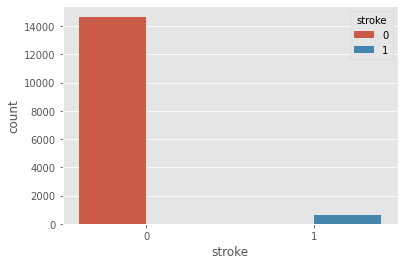

In [278]:
sns.countplot(x='stroke',hue='stroke',data=train);



  As above chart , we can see that the data is imbalanced 


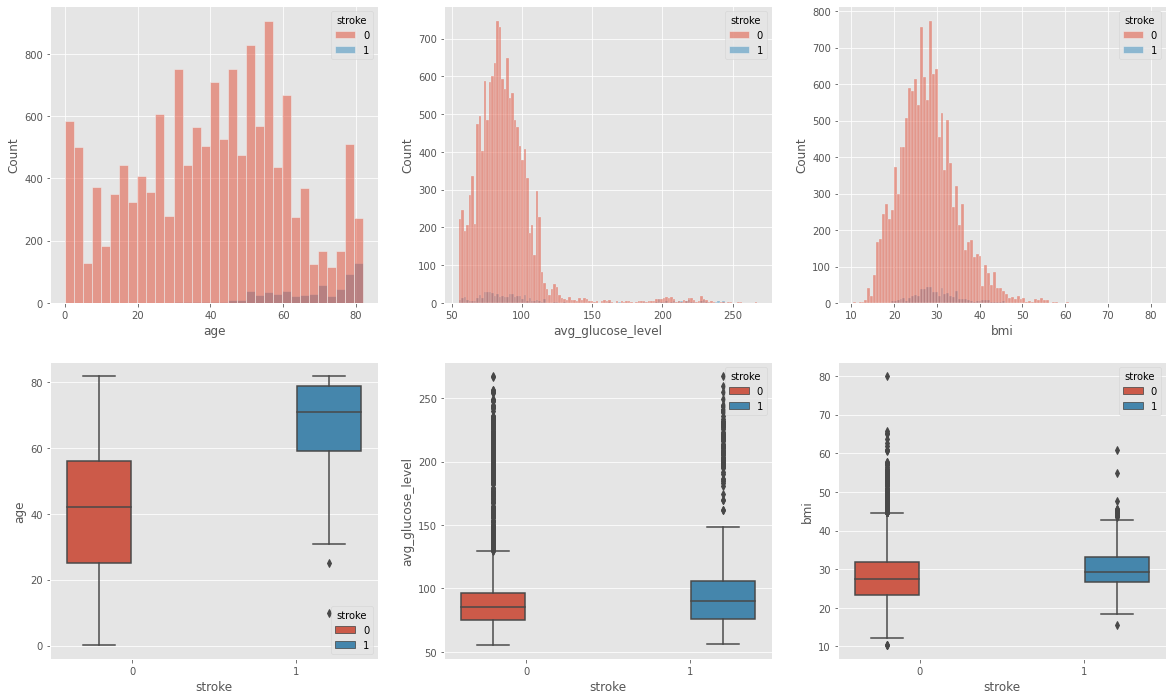

In [279]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.histplot(ax = axes[0, 0], x = 'age', hue = 'stroke', fill = True, data = train)
sns.histplot(ax = axes[0, 1], x = 'avg_glucose_level', hue = 'stroke', fill = True, data = train)
sns.histplot(ax = axes[0, 2], x = 'bmi', hue = 'stroke', fill = True, data = train)
sns.boxplot(ax = axes[1, 0], x = 'stroke', y = 'age', hue = 'stroke', data = train)
sns.boxplot(ax = axes[1, 1], x = 'stroke', y = 'avg_glucose_level', hue = 'stroke', data = train)
sns.boxplot(ax = axes[1, 2], x = 'stroke', y = 'bmi', hue = 'stroke', data = train);

In [280]:
train.value_counts()

id     gender  age   hypertension  heart_disease  ever_married  work_type  Residence_type  avg_glucose_level  bmi   smoking_status  stroke
0      Male    28.0  0             0              Yes           Private    Urban           79.53              31.1  never smoked    0         1
10207  Male    10.0  0             0              No            children   Urban           59.17              20.3  Unknown         0         1
10195  Female  45.0  0             0              Yes           Govt_job   Rural           72.84              38.5  smokes          0         1
10196  Female  57.0  0             0              Yes           Private    Rural           92.99              34.5  never smoked    0         1
10197  Female  52.0  0             0              Yes           Private    Urban           73.33              26.7  never smoked    0         1
                                                                                                                                             

In [281]:
train.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [282]:
train['gender'].value_counts()


Female    9446
Male      5857
Other        1
Name: gender, dtype: int64

In [283]:
index_other=train.index[train['gender']=='Other']
index_other.to_list()

[9363]

In [284]:
#train.iloc[9363]

In [285]:
#train=train.drop(9363)

In [286]:
train['gender'].value_counts()

Female    9446
Male      5857
Other        1
Name: gender, dtype: int64

In [287]:
train.drop('id',axis=1,inplace=True)
train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [288]:
test['gender'].value_counts()


Female    6338
Male      3865
Other        1
Name: gender, dtype: int64

In [289]:
index_other=test.index[test['gender']=='Other']
index_other.to_list()

[4629]

In [290]:
#test=test.drop(4629)

# Let make pipeline for all models

## Let's split data

In [291]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]

        
    

In [292]:
X=train.drop('stroke',axis=1)

In [293]:
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked


In [294]:
y=train['stroke']

In [295]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: stroke, dtype: int64

In [296]:
# split the data into train and test sets
X_train, X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)

In [297]:
# setup a pipeline for preprosessing
numeric_features=['age','hypertension','heart_disease','avg_glucose_level','bmi']
numeric_transformer= Pipeline(steps=[
    ('selector',DataFrameSelector(numeric_features)),
    ('scaler',StandardScaler())
])

In [314]:
# Create a Categorical pipeline
categorical_features=['gender','ever_married','work_type','Residence_type','smoking_status']
categorical_transformer=Pipeline(steps=[
    ('selector',DataFrameSelector(categorical_features)),
     ('imputer',SimpleImputer(strategy='constant',fill_value='missing')),
    ('onhotencode',OneHotEncoder(handle_unknown='ignore'))
])

In [315]:
# Create a MinmaxScaler pipeline
mix_max_transformer=Pipeline(steps=[
    ('selector',DataFrameSelector(numeric_features)),
    ('min_max_scaler',MinMaxScaler())
])

## Function transfer

In [316]:
def select_dtypes(df,dtype):
    return df.select_dtypes(include=[dtype])

In [317]:
dummy_transformer= FunctionTransformer(select_dtypes,kw_args={'dtype':'object'})
dummy_transformer=make_pipeline(dummy_transformer)

In [318]:
# Commbine the preprocessing taks pipeline into one pipeline
preprocessor=ColumnTransformer(
    transformers=[
        ('num',numeric_transformer,numeric_features),
        ('cat',categorical_transformer,categorical_features),
        ('min_max',mix_max_transformer,numeric_features),
        ('dummy',dummy_transformer,categorical_features)
])

# Desige classifier models pipeline


In [319]:
classifiers=[
       ('xgb',XGBClassifier()),
        ('rf',RandomForestClassifier()),
        ('lr',LogisticRegression()) 
   
]

In [320]:
#ipeline=Pipeline([
#   ('preprocessor',preprocessor),
#   ('classifiers',FeatureUnion(transformer_list=classifiers))
#)


In [344]:
# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown = 'ignore'),categorical_features)
    ])

# Define the classifier
classifier = XGBClassifier()

# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# fit the pipeline
pipeline.fit(X_train, y_train)

# evaluate the pipeline on the test set
y_pred = pipeline.predict(X_test)
test_score = accuracy_score(y_test, y_pred)
print('Test accuracy score:', test_score)

Test accuracy score: 0.9549166938908853


In [345]:
y_pred_test=pipeline.predict(test)

In [346]:
pd.DataFrame(y_pred).value_counts()


0    3029
1      32
dtype: int64

In [347]:
submission=pd.read_csv('/kaggle/input/playground-series-s3e2/sample_submission.csv')
submission.head(2)

,id,stroke
0,15304,0.041296
1,15305,0.041296


In [348]:
submission.shape, test.shape

((10204, 2), (10204, 11))

In [349]:
submission['stroke'] = pd.DataFrame(y_pred_test)
submission.head(1000)

,id,stroke
0,15304,0
1,15305,0
2,15306,0
3,15307,0
4,15308,0
...,...,...
995,16299,0
996,16300,0
997,16301,0
998,16302,0


In [350]:
submission.to_csv('submission.csv', index=False)

# Random Forest

In [354]:
# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown = 'ignore'),categorical_features)
    ])

# param grid 
param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
# Define the classifier
#classifier =GridSearchCV(RandomForestClassifier(),param_grid= param_grid,cv=5)
classifier =RandomForestClassifier()
# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# fit the pipeline
pipeline.fit(X_train, y_train)

# evaluate the pipeline on the test set
y_pred = pipeline.predict(X_test)
test_score = accuracy_score(y_test, y_pred)
print('Test accuracy score:', test_score)

Test accuracy score: 0.9552433845148645


In [355]:
y_pred_test=pipeline.predict(test)
submission['stroke'] = pd.DataFrame(y_pred_test)
#submission.to_csv('submission.csv', index=False)

In [ ]:
# define the parameter grid for grid search


# Not finished yet